# Objective

Simulate future asset returns using historical data via Monte Carlo
methods and estimate risk metrics like Value at Risk (VaR) and
Conditional Value at Risk (CVaR) over a chosen time horizon

#This notebook will:

Fetch NSE data.

Simulate future returns via Monte Carlo.

Compute VaR & CVaR.

Plot results clearly.

#Cell 1 – Install and Import Libraries

We use yfinance to download NSE stock data, numpy/pandas for computations, and matplotlib for plotting.

In [1]:
!pip install yfinance numpy pandas matplotlib

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cell 2 – Download Historical Stock Data

We fetch stock prices of Infosys, TCS, and Reliance from NSE.

Only adjusted close prices are used for return calculations.

.dropna() removes missing data points.

In [4]:
# Select a few NSE stocks (you can change tickers as needed)
tickers = ["INFY.NS", "TCS.NS", "RELIANCE.NS"]

# Set the time period
start_date = "2020-01-01"
end_date = "2025-01-01"

# Download Adjusted Close prices
data = yf.download(tickers, start=start_date, end=end_date)["Close"]

# Drop missing values
data = data.dropna()
print("Data Shape:", data.shape)
data.tail()


/tmp/ipython-input-784207189.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  3 of 3 completed

Data Shape: (1238, 3)


Ticker,INFY.NS,RELIANCE.NS,TCS.NS
Date,,,
2024-12-24,1882.562134,1217.885864,4118.851074
2024-12-26,1880.935059,1211.710571,4108.602539
2024-12-27,1890.155273,1216.192749,4104.414551
2024-12-30,1879.554443,1205.883789,4098.451172
2024-12-31,1853.915161,1210.614868,4035.380615


# **Cell 3 – Compute Daily Log Returns**

We use log returns instead of simple returns because they are additive over time and work better for Monte Carlo simulations.

In [5]:
# Compute daily log returns
log_returns = np.log(data / data.shift(1)).dropna()

log_returns.tail()


Ticker,INFY.NS,RELIANCE.NS,TCS.NS
Date,,,
2024-12-24,-0.007957,0.000368,0.005085
2024-12-26,-0.000865,-0.005083,-0.002491
2024-12-27,0.004890,0.003692,-0.001020
2024-12-30,-0.005624,-0.008513,-0.001454
2024-12-31,-0.013735,0.003916,-0.015509


#Cell 4 – Monte Carlo Simulation Function

We estimate mean vector and covariance matrix of returns.

Use np.random.multivariate_normal to generate correlated returns.

Assume equal weights (can be modified).

Compute cumulative portfolio return for each simulation.

Plots multiple simulation paths (e.g., 5000) to show the range of possible outcomes.

In [12]:
def monte_carlo_simulation(returns, num_simulations=5000, horizon=252):
    """
    Simulates future portfolio returns using historical mean and covariance.

    Parameters:
    - returns: DataFrame of historical log returns
    - num_simulations: number of Monte Carlo simulations
    - horizon: number of trading days to simulate

    Returns:
    - simulated cumulative returns
    """
    mean_returns = returns.mean().values
    cov_matrix = returns.cov().values
    num_assets = len(mean_returns)

    # Equal weights portfolio
    weights = np.array([1/num_assets] * num_assets)

    # Store paths
    paths = np.zeros((horizon, num_simulations))

    simulated_returns = []
    for sim in range(num_simulations):
        # Generate correlated daily returns
        simulated_daily = np.random.multivariate_normal(mean_returns, cov_matrix, horizon)
        # Portfolio daily returns
        portfolio_daily = simulated_daily.dot(weights)
        # Convert daily log returns → cumulative return
        cumulative_return = np.exp(portfolio_daily.sum()) - 1
        simulated_returns.append(cumulative_return)
        # Cumulative returns over time
        cumulative_path = np.exp(np.cumsum(portfolio_daily)) - 1
        paths[:, sim] = cumulative_path
    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(paths, alpha=0.3, linewidth=1)
    plt.title(f"Monte Carlo Simulation Paths ({num_simulations} runs, {horizon} days)")
    plt.xlabel("Days")
    plt.ylabel("Cumulative Return")
    plt.grid(True, alpha=0.3)
    plt.show()

    return np.array(simulated_returns)


#Cell 5 – Run Monte Carlo Simulation

We run 5000 simulations to estimate possible portfolio outcomes after 1 year.

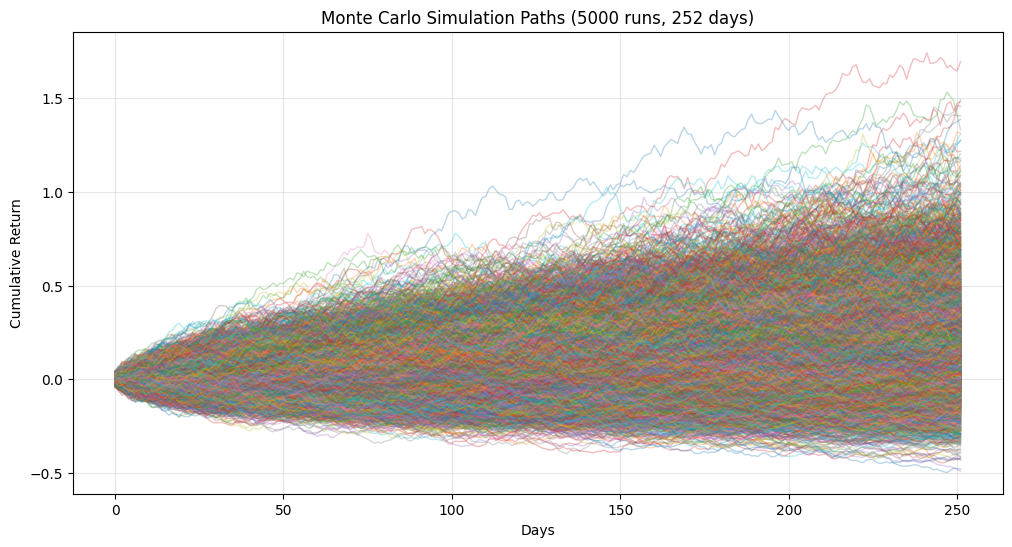

Number of simulations: 5000
Example simulated returns (first 10):
[ 0.07067939  0.0366442   0.53211858  0.58176239  0.35473789 -0.08425294
  0.16183276 -0.04831736 -0.14160432  0.09208078]


In [13]:
# Run simulation for 1 year horizon (252 trading days)
simulated_returns = monte_carlo_simulation(log_returns, num_simulations=5000, horizon=252)

print("Number of simulations:", len(simulated_returns))
print("Example simulated returns (first 10):")
print(simulated_returns[:10])


#Cell 6 – Compute VaR & CVaR

VaR (95%) = worst return expected with 5% probability.

CVaR (95%) = average loss given that losses exceeded VaR (tail risk).

In [8]:
alpha = 0.05  # 5% significance level (95% confidence)

# Value at Risk (VaR)
VaR_95 = np.percentile(simulated_returns, 100 * alpha)

# Conditional Value at Risk (CVaR = Expected Shortfall)
CVaR_95 = simulated_returns[simulated_returns <= VaR_95].mean()

print(f"Estimated 1-Year 95% VaR: {VaR_95:.2%}")
print(f"Estimated 1-Year 95% CVaR: {CVaR_95:.2%}")


Estimated 1-Year 95% VaR: -19.98%
Estimated 1-Year 95% CVaR: -27.19%


#Cell 7 – Visualization

We plot the distribution of simulated returns and highlight where VaR & CVaR fall on the loss tail.

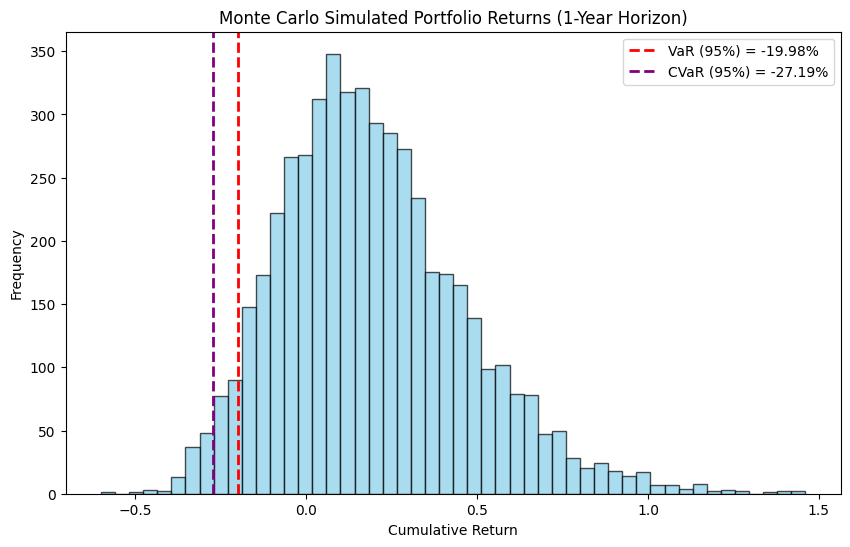

In [9]:
plt.figure(figsize=(10,6))
plt.hist(simulated_returns, bins=50, alpha=0.7, color="skyblue", edgecolor="black")

# Mark VaR & CVaR
plt.axvline(VaR_95, color="red", linestyle="--", linewidth=2, label=f"VaR (95%) = {VaR_95:.2%}")
plt.axvline(CVaR_95, color="purple", linestyle="--", linewidth=2, label=f"CVaR (95%) = {CVaR_95:.2%}")

plt.title("Monte Carlo Simulated Portfolio Returns (1-Year Horizon)")
plt.xlabel("Cumulative Return")
plt.ylabel("Frequency")
plt.legend()
plt.show()


#🔑 Key Takeaways

Monte Carlo Simulation

    -The fan-shaped chart shows the uncertainty in returns.

    -Some paths grow strongly positive, while others decline → highlighting both upside potential and downside risk.

Histogram of Returns

    -The distribution shows whether returns are symmetrical or skewed.

    -If left-skewed → higher downside risk (common in equities).

Value at Risk (VaR)

    Example: If 95% VaR = -19.98%, it means:

    With 95% confidence, the maximum loss over the chosen horizon won’t exceed 19.98%.

    It gives a threshold for “worst expected losses” under normal conditions.

Conditional Value at Risk (CVaR)

    Example: If 95% CVaR = -27.19%, it means:

    In the worst 5% scenarios, the average loss will be around 27.19%.

    This captures tail risk, which VaR alone misses.

#Final Conclusion:

“From the Monte Carlo simulation, we see that while the expected average return is positive, the outcomes have significant variability. The 95% Value at Risk indicates that under normal conditions, losses are unlikely to exceed 19.98% over the horizon. However, the Conditional Value at Risk shows that if extreme downside events occur, the expected loss could be closer to 27.19%. This emphasizes that while the strategy has upside potential, managing tail risk is critical. Such insights help in position sizing, risk management, and portfolio stress testing.”